In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv
from decoding_utils import fit_and_evaluate_regression, fit_and_evaluate_circular_regression, fit_and_evaluate_classification

# Load Model

In [2]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")
eval_dset_path = os.path.join(os.path.dirname(eval_dset_path), 'train.pkl')

epoch=13-val_loss=0.911523.ckpt


In [3]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [4]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_2531949/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [5]:
n_eval_envs = 600

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [6]:
seq_length = 200

# Helper functions

In [7]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer+1)]
    outputs = []
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
            outputs.append(torch.argmax(out).item())
        _hidden_states = model.activations['hidden_states'] # Tuple over layers
        for i_layer in range(model.n_layer+1):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states, outputs

In [8]:
def make_train_test_matrices():
    train_envs = np.arange(1, int(n_eval_envs*0.8))
    test_envs = np.arange(int(n_eval_envs*0.8), n_eval_envs)

    X_train = [[] for _ in range(model.n_layer+1)]
    X_test = [[] for _ in range(model.n_layer+1)]
    Ys_dict = {
        "dist_from_goal": {"Y_train": [], "Y_test": []},
        "euclidean_dist_from_goal": {"Y_train": [], "Y_test": []},
        "angle_from_goal": {"Y_train": [], "Y_test": []},
        "node_identity": {"Y_train": [], "Y_test": []},
        'is_goal': {"Y_train": [], "Y_test": []},
        "action": {"Y_train": [], "Y_test": []},
        "x": {"Y_train": [], "Y_test": []},
        "y": {"Y_train": [], "Y_test": []},
        "delta_x": {"Y_train": [], "Y_test": []},
        "delta_y": {"Y_train": [], "Y_test": []}
    }

    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
        seen_states = np.unique(seen_states, axis=0) 
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        hidden_states, outputs = run_model(traj, model, seen_states, seq_length)
        goal_node = env.node_map_encoding_to_pos[tuple(env.goal.tolist())]
        for state_idx, state_feature in enumerate(seen_states):
            state_feature_tuple = tuple(state_feature.tolist())
            state_feature_tuple = tuple(state_feature.tolist())
            action = outputs[state_idx]
            d = dist_from_goal[state_feature_tuple]
            node_identity = env.node_map_encoding_to_pos[state_feature_tuple]
            
            Y_key = "Y_train" if i_eval in train_envs else "Y_test"
            Ys_dict["dist_from_goal"][Y_key].append(d)
            Ys_dict["angle_from_goal"][Y_key].append(
                np.arctan2(goal_node[1] - node_identity[1], goal_node[0] - node_identity[0])
                )
            Ys_dict['euclidean_dist_from_goal'][Y_key].append(
                np.linalg.norm(np.array(goal_node) - np.array(node_identity))
                )
            Ys_dict["node_identity"][Y_key].append(node_identity)
            Ys_dict["is_goal"][Y_key].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["action"][Y_key].append(action)
            Ys_dict["x"][Y_key].append(node_identity[0])
            Ys_dict["y"][Y_key].append(node_identity[1])
            Ys_dict["delta_x"][Y_key].append(goal_node[0] - node_identity[0])
            Ys_dict["delta_y"][Y_key].append(goal_node[1] - node_identity[1])
            for layer in range(len(hidden_states)):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                hidden_state = hidden_state.squeeze()[-1].squeeze()
                if i_eval in train_envs:
                    X_train[layer].append(hidden_state)
                else:
                    X_test[layer].append(hidden_state)
        torch.cuda.empty_cache()

    return X_train, X_test, Ys_dict

In [9]:
def plot_heatmaps(test_score, Ys_dict):
    n_layers = len(test_score)
    
    # Get x and y test data
    X_test = Ys_dict['x']['Y_test']
    Y_test = Ys_dict['y']['Y_test']
    
    # Create figure with subplots for each layer
    fig, axes = plt.subplots(1, n_layers, figsize=(5*n_layers, 5))
    if n_layers == 1:
        axes = [axes]
    score_grids = []
    
    for layer_idx, layer_scores in enumerate(test_score):
        # Assuming X_test and Y_test contain coordinates
        # First, create a grid to store average scores
        x_unique = np.unique(X_test)
        y_unique = np.unique(Y_test)
        
        # Initialize grid with NaN values
        score_grid = np.full((len(y_unique), len(x_unique)), np.nan)
        
        # Calculate average score for each x,y location
        for x_idx, x_val in enumerate(x_unique):
            for y_idx, y_val in enumerate(y_unique):
                # Find indices where X_test == x_val and Y_test == y_val
                mask = (X_test == x_val) & (Y_test == y_val)
                if np.any(mask):
                    # Calculate average score for this x,y location
                    score_grid[y_idx, x_idx] = np.mean(np.array(layer_scores)[mask])
        score_grids.append(score_grid)

    vmin = min(m.min() for m in score_grids)
    vmax = max(m.max() for m in score_grids)    
    for layer_idx, score_grid in enumerate(score_grids):       # Plot heatmap
        ax = axes[layer_idx]
        heatmap = sns.heatmap(score_grid, annot=True, fmt=".2f", cmap="viridis", 
                              xticklabels=x_unique, yticklabels=y_unique, ax=ax,
                              vmin=vmin, vmax=vmax)
        
        ax.set_title(f'Layer {layer_idx+1}')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

# Collect data and run regressions

In [10]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [11]:
results = {
    'gamma': [],
    'test_score': [],
    'test_y': [],
    'test_pred': [],
}
for gamma in np.arange(0.4, 1.0, 0.1):
    _Ys_dict_train = [gamma**d for d in Ys_dict["euclidean_dist_from_goal"]["Y_train"]]
    _Ys_dict_test = [gamma**d for d in Ys_dict["euclidean_dist_from_goal"]["Y_test"]]
    _results = fit_and_evaluate_regression(X_train, _Ys_dict_train, X_test, _Ys_dict_test, make_plot=False)
    results['gamma'].append(gamma)
    results['test_score'].append(_results[1])
    results['test_y'].append(_results[2])
    results['test_pred'].append(_results[3])

with open('pickles/09_query_token_decoding_q_value_euclidean_dist.pkl', 'wb') as f:
    pickle.dump(results, f)

Layer 0:
Best alpha: 10000.000
Train R2: 0.003
Test R2: -0.007

Layer 1:
Best alpha: 166.810
Train R2: 0.862
Test R2: 0.852

Layer 2:
Best alpha: 59.948
Train R2: 0.934
Test R2: 0.929

Layer 3:
Best alpha: 59.948
Train R2: 0.946
Test R2: 0.939

Layer 0:
Best alpha: 10000.000
Train R2: 0.004
Test R2: -0.008

Layer 1:
Best alpha: 166.810
Train R2: 0.803
Test R2: 0.787

Layer 2:
Best alpha: 59.948
Train R2: 0.916
Test R2: 0.907

Layer 3:
Best alpha: 21.544
Train R2: 0.930
Test R2: 0.919

Layer 0:
Best alpha: 10000.000
Train R2: 0.005
Test R2: -0.009

Layer 1:
Best alpha: 166.810
Train R2: 0.744
Test R2: 0.721

Layer 2:
Best alpha: 59.948
Train R2: 0.898
Test R2: 0.885

Layer 3:
Best alpha: 21.544
Train R2: 0.912
Test R2: 0.898

Layer 0:
Best alpha: 10000.000
Train R2: 0.005
Test R2: -0.009

Layer 1:
Best alpha: 166.810
Train R2: 0.688
Test R2: 0.659

Layer 2:
Best alpha: 59.948
Train R2: 0.881
Test R2: 0.865

Layer 3:
Best alpha: 21.544
Train R2: 0.895
Test R2: 0.877

Layer 0:
Best alpha:

Layer 0:
Best alpha: 10000.000
Train mean circular error: 1.405 radians (80.5°)
Test mean circular error: 1.534 radians (87.9°)



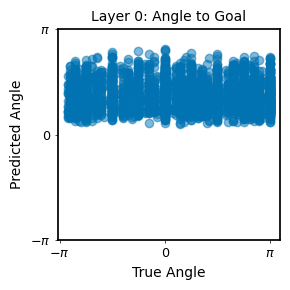

Layer 1:
Best alpha: 59.948
Train mean circular error: 0.674 radians (38.6°)
Test mean circular error: 0.769 radians (44.0°)



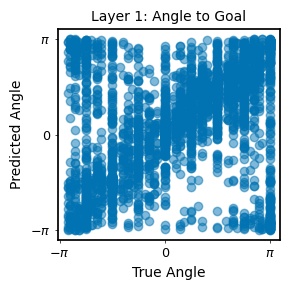

Layer 2:
Best alpha: 166.810
Train mean circular error: 0.185 radians (10.6°)
Test mean circular error: 0.210 radians (12.1°)



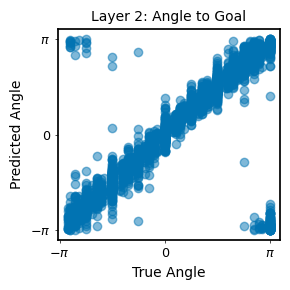

Layer 3:
Best alpha: 2.783
Train mean circular error: 0.141 radians (8.1°)
Test mean circular error: 0.156 radians (8.9°)



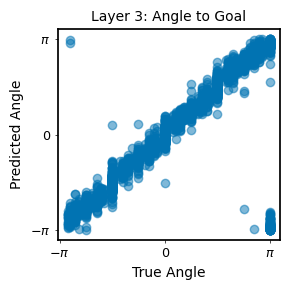

In [12]:
pipeline, test_score, test_y, test_pred = fit_and_evaluate_circular_regression(
    X_train, 
    Ys_dict["angle_from_goal"]["Y_train"], 
    X_test, 
    Ys_dict["angle_from_goal"]["Y_test"],
)
results = {
    'test_score': test_score,
    'test_y': test_y,
    'test_pred': test_pred,
}
with open('pickles/09_query_token_decoding_goal_angle.pkl', 'wb') as f:
    pickle.dump(results, f)

Layer 0:
Best alpha: 10000.000
Train R2: 0.004
Test R2: -0.005

Layer 1:
Best alpha: 166.810
Train R2: 0.670
Test R2: 0.640

Layer 2:
Best alpha: 166.810
Train R2: 0.899
Test R2: 0.891

Layer 3:
Best alpha: 21.544
Train R2: 0.894
Test R2: 0.880

Layer 0:
Best alpha: 10000.000
Train R2: 0.002
Test R2: -0.003

Layer 1:
Best alpha: 166.810
Train R2: 0.682
Test R2: 0.643

Layer 2:
Best alpha: 59.948
Train R2: 0.904
Test R2: 0.892

Layer 3:
Best alpha: 21.544
Train R2: 0.895
Test R2: 0.876



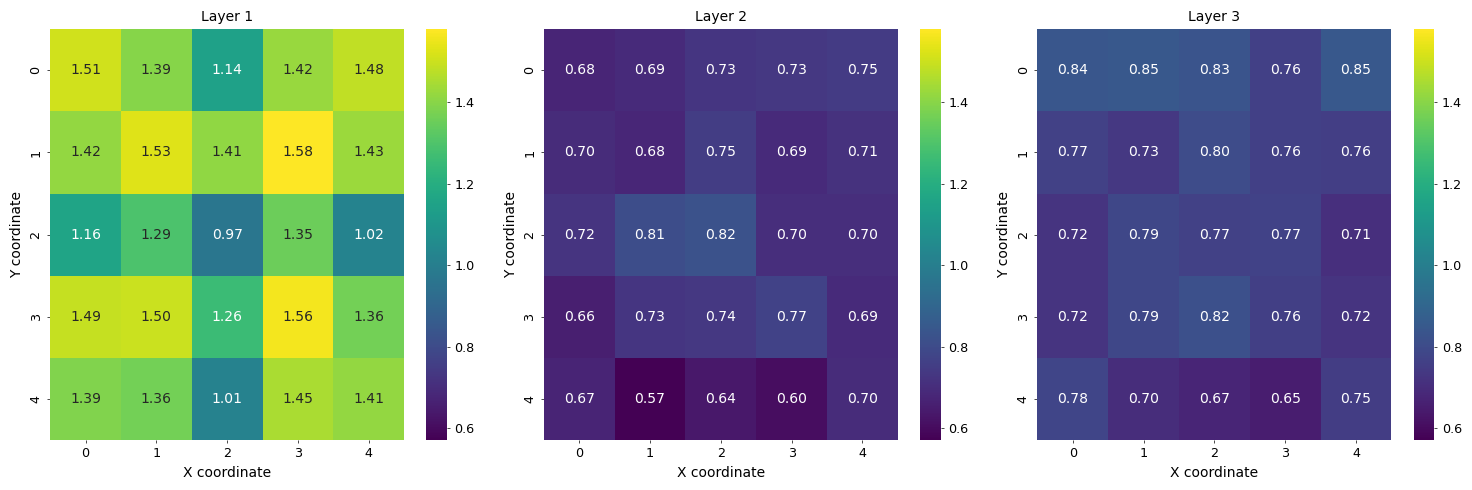

In [ ]:
results = {
    'test_score_x': [],
    'test_score_y': [],
    'test_x': [],
    'test_pred_x': [],
    'test_y': [],
    'test_pred_y': [],
}
pipeline, test_score_x, test_x, test_pred_x = fit_and_evaluate_regression(
    X_train, 
    Ys_dict["x"]["Y_train"], 
    X_test, 
    Ys_dict["x"]["Y_test"],
    make_plot=False,
)

pipeline, test_score_y, test_y, test_pred_y = fit_and_evaluate_regression(
    X_train, 
    Ys_dict["y"]["Y_train"], 
    X_test, 
    Ys_dict["y"]["Y_test"],
    make_plot=False,
)

plot_heatmaps([np.array(test_score_x[i]) + np.array(test_score_y[i]) for i in range(1, len(test_score_x))], Ys_dict)

results['test_score_x'] = test_score_x
results['test_score_y'] = test_score_y
results['test_x'] = test_x
results['test_pred_x'] = test_pred_x
results['test_y'] = test_y
results['test_pred_y'] = test_pred_y
with open('pickles/09_query_token_decoding_x_y.pkl', 'wb') as f:
    pickle.dump(results, f)



In [14]:
results = {
    'gamma': [],
    'test_score': [],
    'test_y': [],
    'test_pred': [],
}
for gamma in np.arange(0.4, 1.0, 0.1):
    _Ys_dict_train = [gamma**d for d in Ys_dict["dist_from_goal"]["Y_train"]]
    _Ys_dict_test = [gamma**d for d in Ys_dict["dist_from_goal"]["Y_test"]]
    _results = fit_and_evaluate_regression(X_train, _Ys_dict_train, X_test, _Ys_dict_test, make_plot=False)
    results['gamma'].append(gamma)
    results['test_score'].append(_results[1])
    results['test_y'].append(_results[2])
    results['test_pred'].append(_results[3])

with open('pickles/09_query_token_decoding_q_value_dist.pkl', 'wb') as f:
    pickle.dump(results, f)

Layer 0:
Best alpha: 10000.000
Train R2: 0.003
Test R2: -0.006

Layer 1:
Best alpha: 166.810
Train R2: 0.896
Test R2: 0.893

Layer 2:
Best alpha: 59.948
Train R2: 0.945
Test R2: 0.941

Layer 3:
Best alpha: 21.544
Train R2: 0.955
Test R2: 0.949

Layer 0:
Best alpha: 10000.000
Train R2: 0.004
Test R2: -0.007

Layer 1:
Best alpha: 166.810
Train R2: 0.842
Test R2: 0.834

Layer 2:
Best alpha: 166.810
Train R2: 0.926
Test R2: 0.922

Layer 3:
Best alpha: 21.544
Train R2: 0.941
Test R2: 0.932

Layer 0:
Best alpha: 10000.000
Train R2: 0.004
Test R2: -0.008

Layer 1:
Best alpha: 166.810
Train R2: 0.778
Test R2: 0.765

Layer 2:
Best alpha: 59.948
Train R2: 0.907
Test R2: 0.897

Layer 3:
Best alpha: 21.544
Train R2: 0.924
Test R2: 0.912

Layer 0:
Best alpha: 10000.000
Train R2: 0.005
Test R2: -0.009

Layer 1:
Best alpha: 166.810
Train R2: 0.710
Test R2: 0.690

Layer 2:
Best alpha: 59.948
Train R2: 0.884
Test R2: 0.870

Layer 3:
Best alpha: 21.544
Train R2: 0.904
Test R2: 0.889

Layer 0:
Best alpha